In [12]:
import warnings
from statistics import mean

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from matplotlib import pyplot
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, average_precision_score,
                             confusion_matrix, recall_score, roc_auc_score)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")

In [13]:
%pip install prettytable

Note: you may need to restart the kernel to use updated packages.


# 1. Data Preprocessing

<h2>1.1 Loading Dataset <h2>

In [14]:
# Read the csv file
df_train = pd.read_csv(
    "R:/The-Grand-Complete-Data-Science-Materials-main/ML Projects/backorder-prediction/test_dataset/Test_Dataset.csv")
df_test = pd.read_csv(
    "R:/The-Grand-Complete-Data-Science-Materials-main/ML Projects/backorder-prediction/test_dataset/Test_Dataset.csv")


In [15]:
df_train.tail()


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
4,100005,5,9,0,0,0,1,2,3,5,...,0,0.99,0.99,0,No,No,No,Yes,No,No
5,100006,3,9,0,0,0,0,0,0,0,...,0,0.99,0.99,0,No,No,No,Yes,No,No
6,100007,515,12,0,0,0,0,0,11,35,...,0,0.73,0.79,0,No,No,No,Yes,No,No
7,100008,54,8,0,0,0,0,1,9,11,...,0,0.83,0.86,0,No,No,No,Yes,No,No
8,100009,7,12,0,11,11,11,2,6,9,...,0,0.62,0.62,0,No,No,Yes,Yes,No,No


In [16]:
df_test.tail()


,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
4,100005,5,9,0,0,0,1,2,3,5,...,0,0.99,0.99,0,No,No,No,Yes,No,No
5,100006,3,9,0,0,0,0,0,0,0,...,0,0.99,0.99,0,No,No,No,Yes,No,No
6,100007,515,12,0,0,0,0,0,11,35,...,0,0.73,0.79,0,No,No,No,Yes,No,No
7,100008,54,8,0,0,0,0,1,9,11,...,0,0.83,0.86,0,No,No,No,Yes,No,No
8,100009,7,12,0,11,11,11,2,6,9,...,0,0.62,0.62,0,No,No,Yes,Yes,No,No


## 1.2 Dropping the last record which contains NaN

In [17]:
# Dropping last record of train and test dataset
df_train = df_train[:-1]
df_test = df_test[:-1]


# 2. Feature Engineering

## 2.1 Converting  Boolean values to Binary values 

In [18]:
# Encode categorical columns with values Yes and No to 1 and 0 respectively
def encode_bool(df):
    # Creating dictionary with mapping values
    dict_map_bool = {'Yes': 1.0, 'No': 0.0}

    df['deck_risk'] = df['deck_risk'].map(dict_map_bool)
    df['potential_issue'] = df['potential_issue'].map(dict_map_bool)
    df['oe_constraint'] = df['oe_constraint'].map(dict_map_bool)
    df['ppap_risk'] = df['ppap_risk'].map(dict_map_bool)
    df['stop_auto_buy'] = df['stop_auto_buy'].map(dict_map_bool)
    df['rev_stop'] = df['rev_stop'].map(dict_map_bool)
    df['went_on_backorder'] = df['went_on_backorder'].map(dict_map_bool)

    return df


df_train = encode_bool(df_train)
df_test = encode_bool(df_test)


In [19]:
df_test.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,100001,55,12,0,231,348,465,30,183,356,...,0,0.07,0.19,0,0.0,0.0,0.0,1.0,0.0,1.0
1,100002,1,8,0,2,4,6,0,2,3,...,0,0.85,0.64,0,0.0,0.0,1.0,1.0,0.0,0.0
2,100003,0,8,0,0,0,0,0,0,1,...,0,0.91,0.95,0,0.0,0.0,0.0,1.0,0.0,1.0
3,100004,2,8,2,10,18,24,3,7,14,...,0,0.77,0.76,0,0.0,0.0,0.0,1.0,0.0,1.0
4,100005,5,9,0,0,0,1,2,3,5,...,0,0.99,0.99,0,0.0,0.0,0.0,1.0,0.0,0.0


## 2.2 Replacing unknown values

In [20]:
# Replacing -99 in perfomance columns with nan

def replace_unknown(df):
    df.perf_6_month_avg.replace({-99.0: np.nan}, inplace=True)
    df.perf_12_month_avg.replace({-99.0: np.nan}, inplace=True)

    return df


df_train = replace_unknown(df_train)
df_test = replace_unknown(df_test)


In [21]:
df_train.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,100001,55,12,0,231,348,465,30,183,356,...,0,0.07,0.19,0,0.0,0.0,0.0,1.0,0.0,1.0
1,100002,1,8,0,2,4,6,0,2,3,...,0,0.85,0.64,0,0.0,0.0,1.0,1.0,0.0,0.0
2,100003,0,8,0,0,0,0,0,0,1,...,0,0.91,0.95,0,0.0,0.0,0.0,1.0,0.0,1.0
3,100004,2,8,2,10,18,24,3,7,14,...,0,0.77,0.76,0,0.0,0.0,0.0,1.0,0.0,1.0
4,100005,5,9,0,0,0,1,2,3,5,...,0,0.99,0.99,0,0.0,0.0,0.0,1.0,0.0,0.0


## 2.3 Handling missing values

In [22]:
X_train_iter = df_train.copy()
X_test_iter = df_test.copy()


In [23]:
# Using Iterative Imputer method to replace missing values

iter = IterativeImputer(max_iter=10, random_state=0)
iter.fit(X_train_iter)
X_train_iter[:] = iter.transform(X_train_iter)
X_test_iter[:] = iter.transform(X_test_iter)


## 2.4 Correlation of numerical features with target variable

In [24]:
# Numerical columns list
num_col_list = ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month',
                'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
                'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


In [25]:
# Correlation using Point Biserial correlation
y_train = df_train['went_on_backorder']


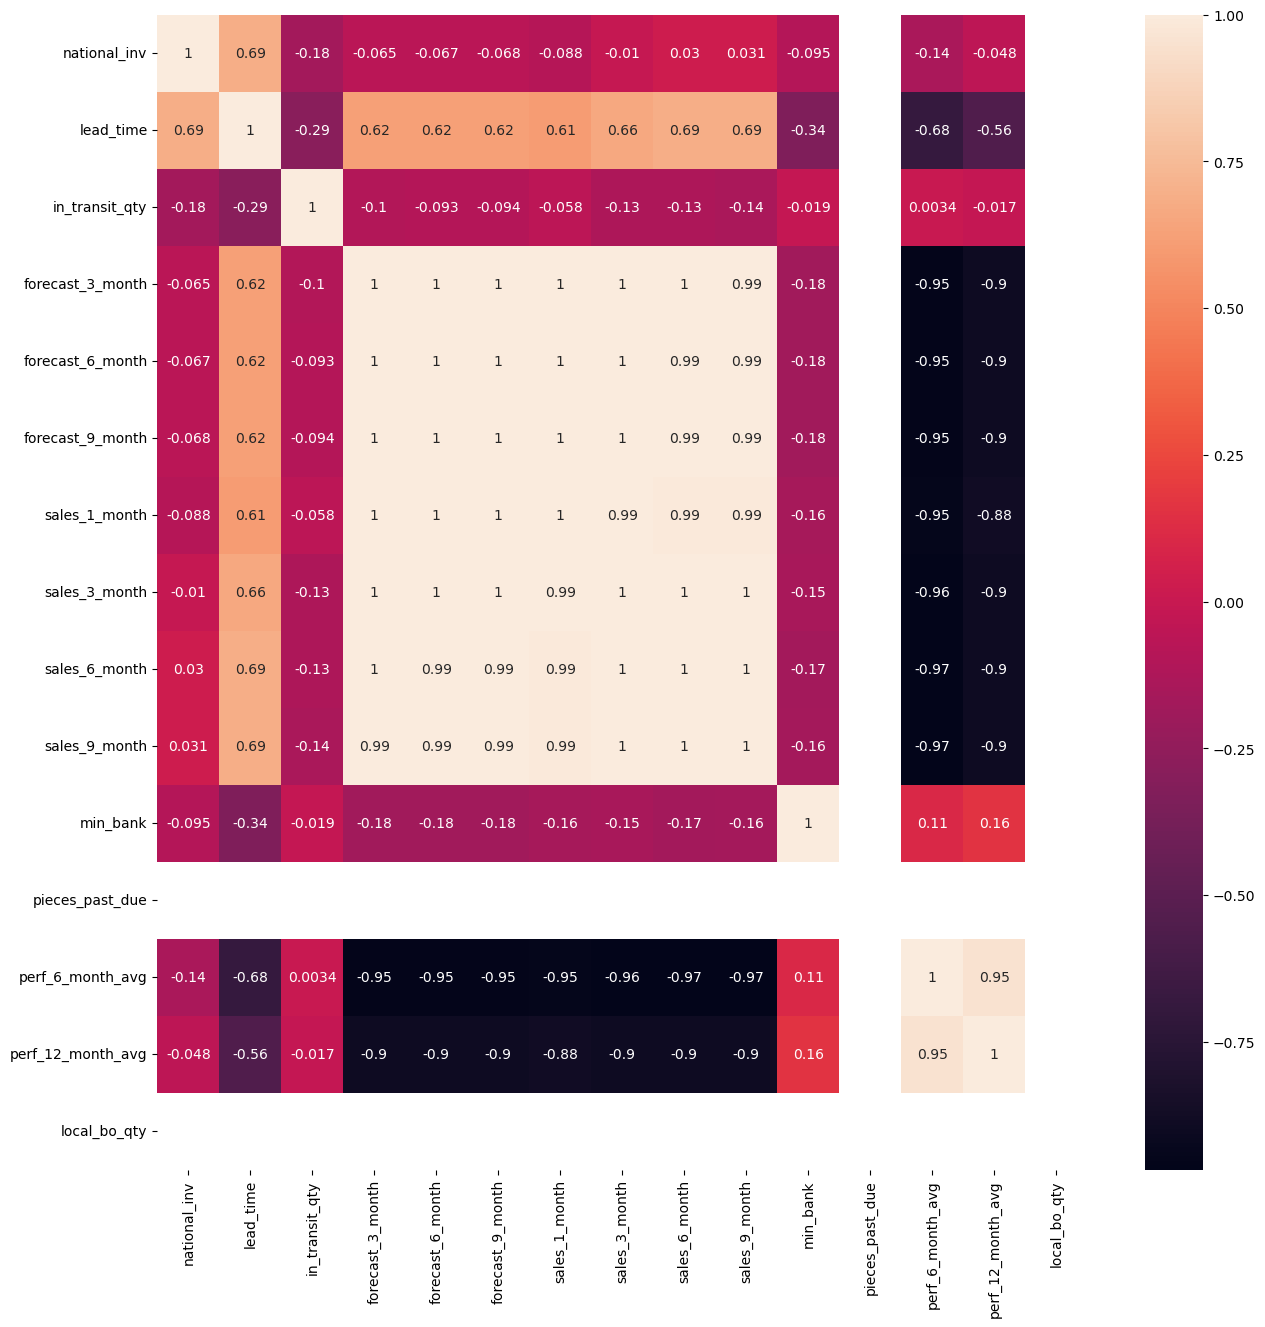

In [26]:
# Subset dataframe to only keep columns in the list
df_num_col = df_train[num_col_list]

# Generate heatmap
fig, ax = plt.subplots(figsize=(15, 15), facecolor='none')
sns.heatmap(df_num_col.corr(), annot=True)
fig.set_facecolor('none')
plt.savefig('images/heatmap.png')
plt.show()


* Based on the data analysis, it was discovered that the columns related to performance demonstrated the highest correlation with the target variable.
* In addition to the performance columns, the lead_time feature also displayed some degree of correlation with the target variable.
* On the other hand, the other columns in the dataset did not exhibit substantial correlation with the target variable.
* Notably, only two features, namely local_bo_qty and pieces_past_due, demonstrated a positive correlation with the target variable.


## 2.5 Raw Data features Visualization Before Transformations

In [27]:
df_train_num_untrans = df_train.copy()
df_train_num_untrans = df_train_num_untrans.drop(
    ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'], axis=1)


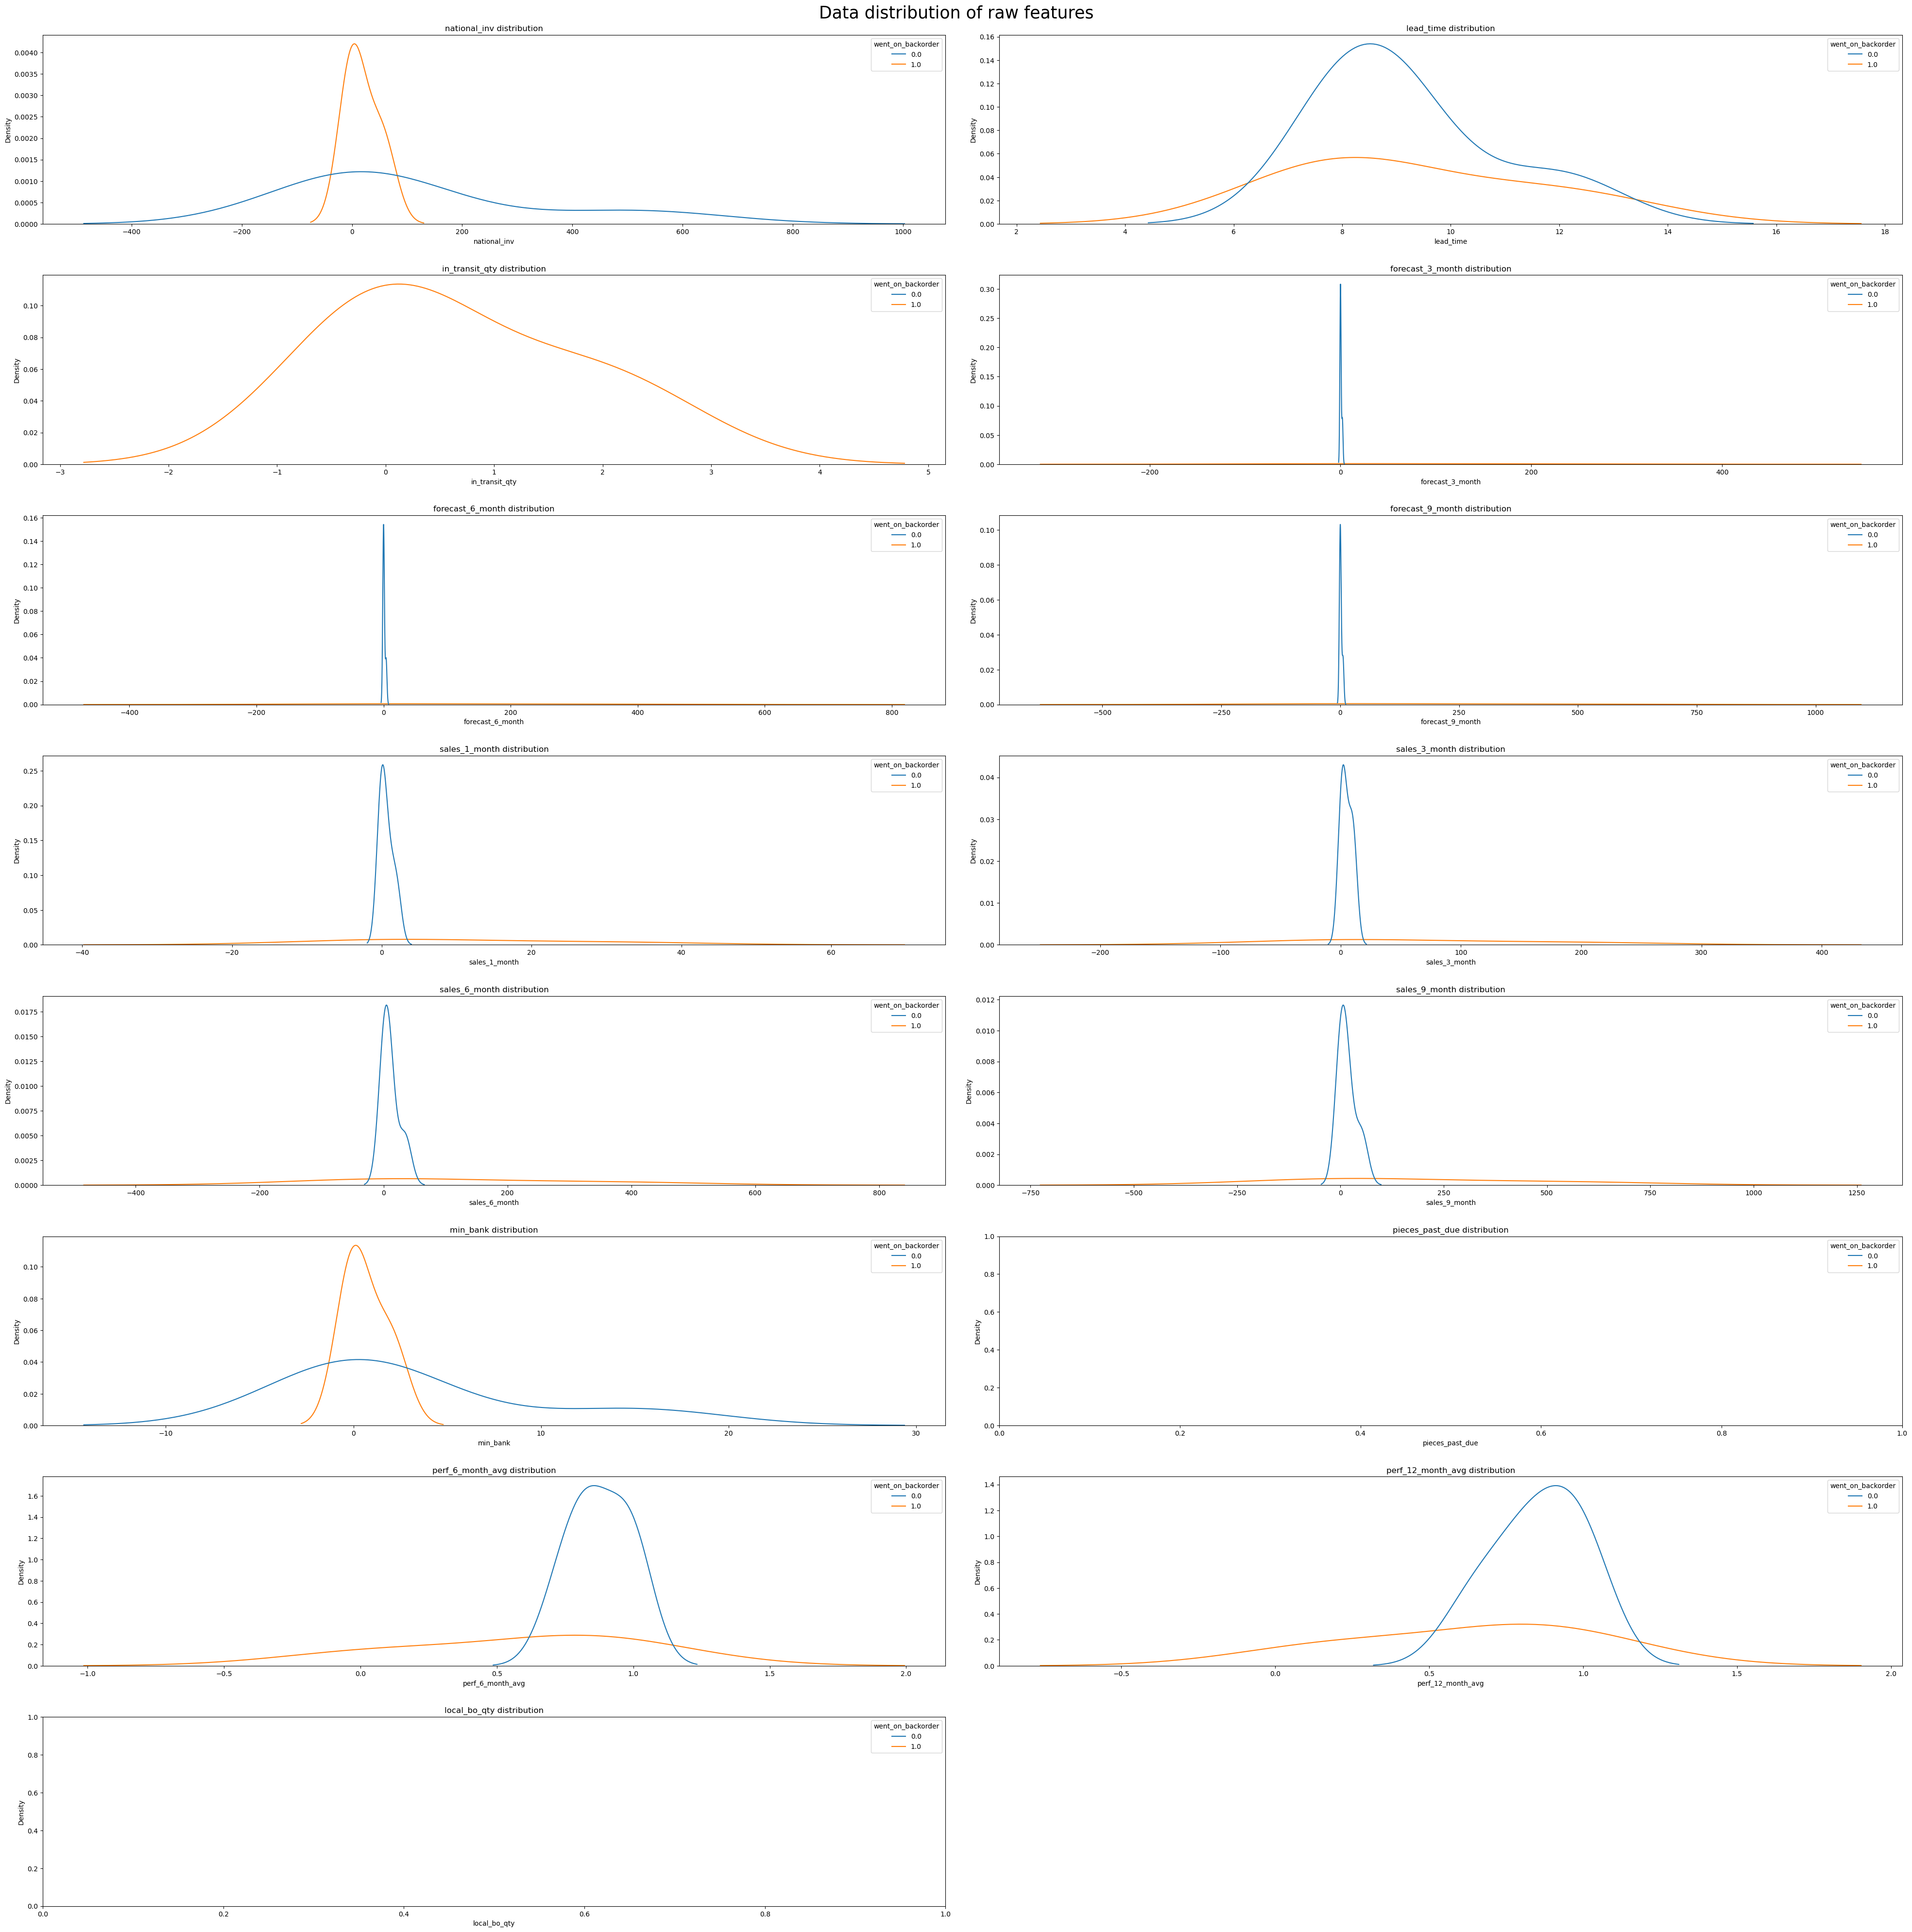

In [28]:
# Distribution of raw features before transformations
fig = plt.figure(figsize=(40, 40), facecolor='None')
for idx, val in enumerate(df_train_num_untrans.drop(['went_on_backorder'], axis=1)):
    ax1 = fig.add_subplot(8, 2, idx + 1)
    ax1.title.set_text(val + ' distribution')
    sns.kdeplot(data=df_train_num_untrans, x=val, hue='went_on_backorder')

fig.tight_layout(pad=3.0)
fig.suptitle("Data distribution of raw features", fontsize=25, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/raw_features.png')
plt.show()


* It is difficult to seperate out the classes in these features as they are high overlapping

## 2.6 Transformed Features Visualization

In [29]:
X_train_iter_stand = X_train_iter.copy()
X_test_iter_stand = X_test_iter.copy()


In [30]:
# Applying Standard Scaler

sc = StandardScaler().fit(X_train_iter_stand[num_col_list].values)
X_tr_sc_num_feat = sc.transform(X_train_iter_stand[num_col_list].values)
X_te_sc_num_feat = sc.transform(X_test_iter_stand[num_col_list].values)

X_tr_sc_num_feat = pd.DataFrame(
    X_tr_sc_num_feat, index=X_train_iter_stand.index, columns=num_col_list)
X_te_sc_num_feat = pd.DataFrame(
    X_te_sc_num_feat, index=X_test_iter_stand.index, columns=num_col_list)


In [31]:
# Assigning numerical columns to original dataframe
for i in num_col_list:
    X_train_iter_stand[i] = X_tr_sc_num_feat[i]
    X_test_iter_stand[i] = X_te_sc_num_feat[i]


In [32]:
# Random Undersample the dataset to balance the data

undersample = RandomUnderSampler()
X_train_iter_under, y_train_iter_under = undersample.fit_resample(
    X_train_iter_stand, y_train)


In [33]:
# Creating undersampled dataframes for train set

X_train_iter_under = pd.DataFrame(
    X_train_iter_under, columns=X_train_iter_stand.columns)
y_train_iter_under = pd.DataFrame(
    y_train_iter_under, columns=['went_on_backorder'])


In [34]:
# Creating dataframes with numerical features for train and test set
def create_num_feature(df):
    return df.drop(
        columns=['sku', 'potential_issue', 'deck_risk',
                 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop'],
        axis=1
    )


X_train_iter_under_num = create_num_feature(X_train_iter_under)
X_test_iter_num = create_num_feature(X_test_iter_stand)


## 2.7 Creating New Transformed features

In [35]:
# Function to fit logistic regression model
def model(df_final, y):
    log_reg = LogisticRegression()
    log_reg.fit(df_final, y)
    return log_reg


# Function to perform addition of features
def add(df, num_cols):
    for i in num_cols:
        for j in num_cols:
            if (i != j):
                df[i + '_' + j + '_add'] = df[i] + df[j]
    return df


# Function to perform multiplication of features
def mult(df, num_cols):
    for i in num_cols:
        for j in num_cols:
            if (i != j):
                df[i + '_' + j + '_mult'] = df[i] * df[j]
    return df


# Function to perform inverse of features
def inv(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'inv'] = 1 / (df[i] + 0.001)

    return df


# Function to perform square of features
def square(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'square'] = df[i] * df[i]
    return df


# Function to perform square root of features
def sqrt(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'square_root'] = np.sqrt(abs(df[i]))
    return df


# Function to perform log of features
def log(df, num_cols):
    for i in num_cols:
        df[i + '_' + 'log'] = (np.log(abs(df[i]) + 1))
    return df


In [36]:
def apply_transform(df_iter_num, num_col_list):
    df = add(df_iter_num, num_col_list)
    df = mult(df, num_col_list)
    df = inv(df, num_col_list)
    df = square(df, num_col_list)
    df = sqrt(df, num_col_list)
    df = log(df, num_col_list)
    return df


X_train_iter_trans = apply_transform(X_train_iter_under_num, num_col_list)
X_test_iter_trans = apply_transform(X_test_iter_num, num_col_list)


In [37]:
y_train_iter_trans = X_train_iter_trans['went_on_backorder'].values
y_test_iter_trans = X_test_iter_trans['went_on_backorder'].values

X_train_iter_trans = X_train_iter_trans.drop(['went_on_backorder'], axis=1)
X_test_iter_trans = X_test_iter_trans.drop(['went_on_backorder'], axis=1)

# applying logistic regression
model = model(X_train_iter_trans, y_train_iter_trans)
importances = model.coef_
abs_imp = np.abs(importances[0])

# get the sorting indices
sorted_idx = (-abs_imp).argsort()


In [38]:
# print top 20 most important columns
for i in sorted_idx[:20]:
    print(X_train_iter_trans.columns[i])


perf_12_month_avg_perf_6_month_avg_add
perf_6_month_avg_perf_12_month_avg_add
in_transit_qty_perf_12_month_avg_add
perf_12_month_avg_in_transit_qty_add
perf_12_month_avg_sales_1_month_add
sales_1_month_perf_12_month_avg_add
forecast_3_month_perf_12_month_avg_add
perf_12_month_avg_forecast_3_month_add
perf_12_month_avg_forecast_6_month_add
forecast_6_month_perf_12_month_avg_add
perf_12_month_avg_forecast_9_month_add
forecast_9_month_perf_12_month_avg_add
sales_6_month_perf_12_month_avg_add
perf_12_month_avg_sales_6_month_add
local_bo_qty_perf_12_month_avg_add
perf_12_month_avg
perf_12_month_avg_local_bo_qty_add
pieces_past_due_perf_12_month_avg_add
perf_12_month_avg_pieces_past_due_add
perf_12_month_avg_sales_9_month_add


In [39]:
X_train_iter_trans_plt = X_train_iter_trans.copy()
X_train_iter_trans_plt['went_on_backorder'] = y_train_iter_trans


### 2.8 Plot of original and transformed features

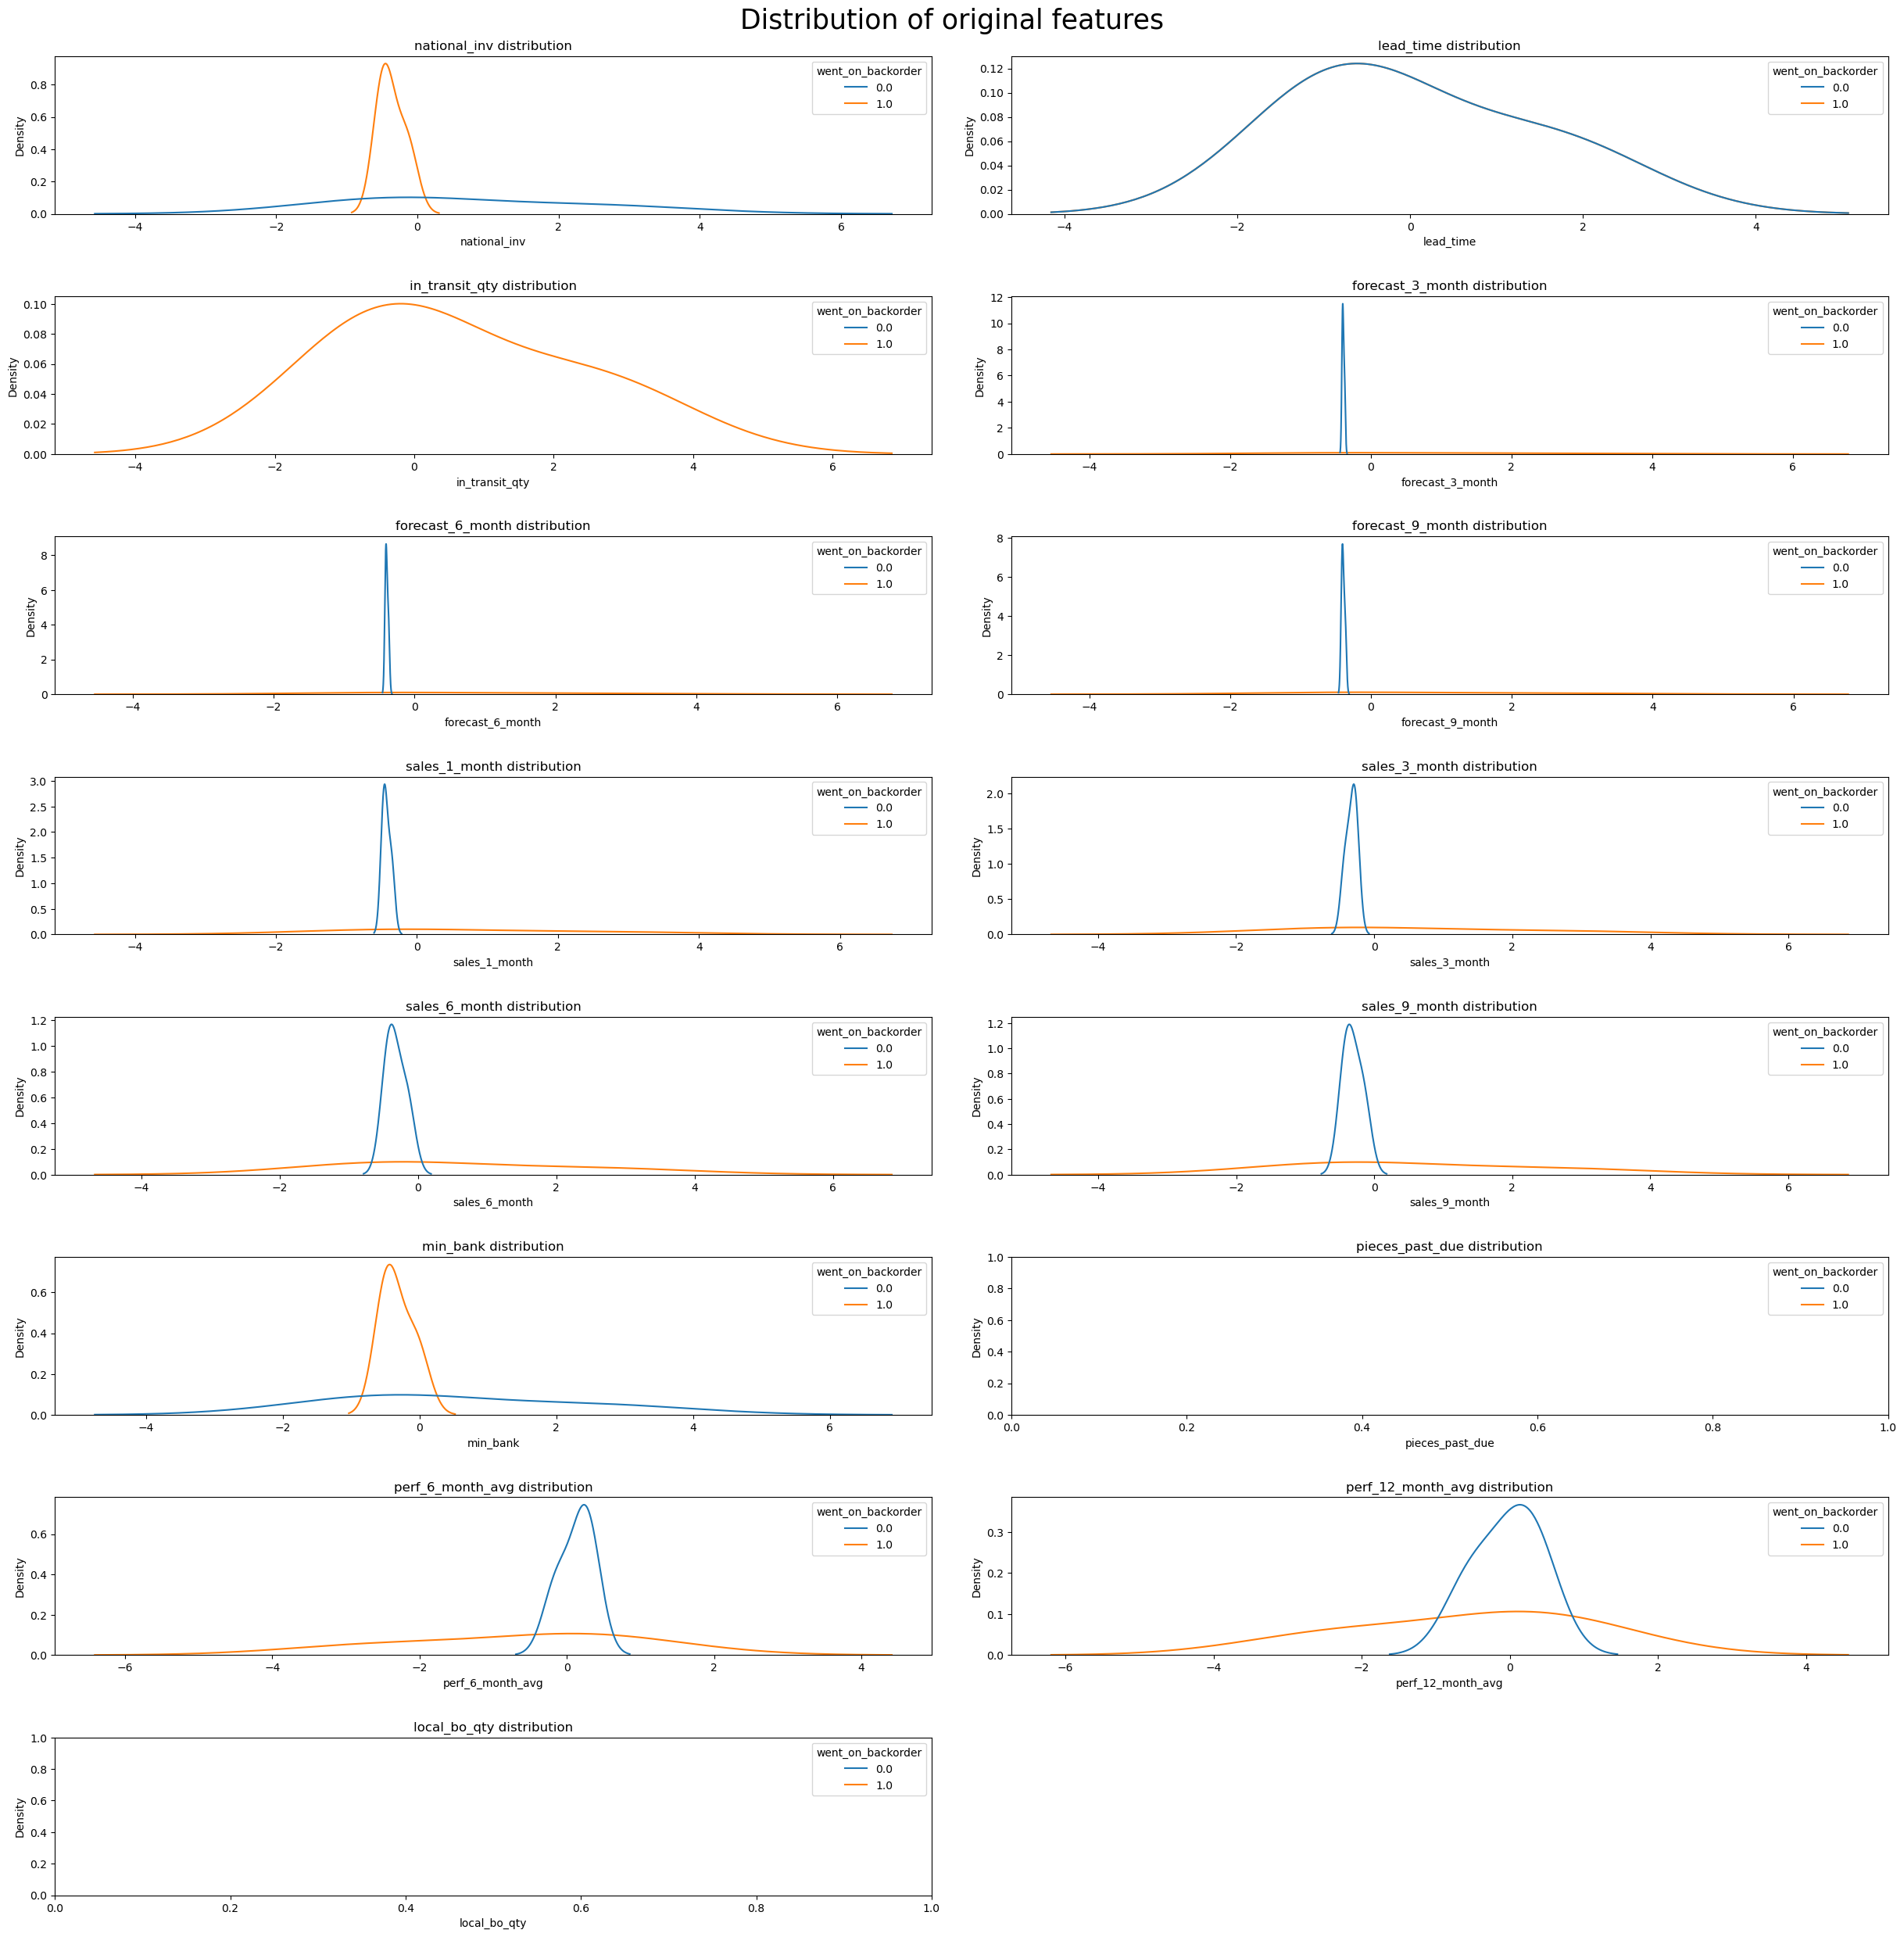

In [40]:
# Distribution of original features
fig = plt.figure(figsize=(25, 25))
for i, j in enumerate(num_col_list):
    ax1 = fig.add_subplot(8, 2, i + 1)
    p = X_train_iter_trans[j]
    ax1.title.set_text(j + ' distribution')
    sns.kdeplot(data=X_train_iter_trans_plt,
                x=num_col_list[i], hue='went_on_backorder')

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of original features", fontsize=25, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/original_after_trans.png')
plt.show()


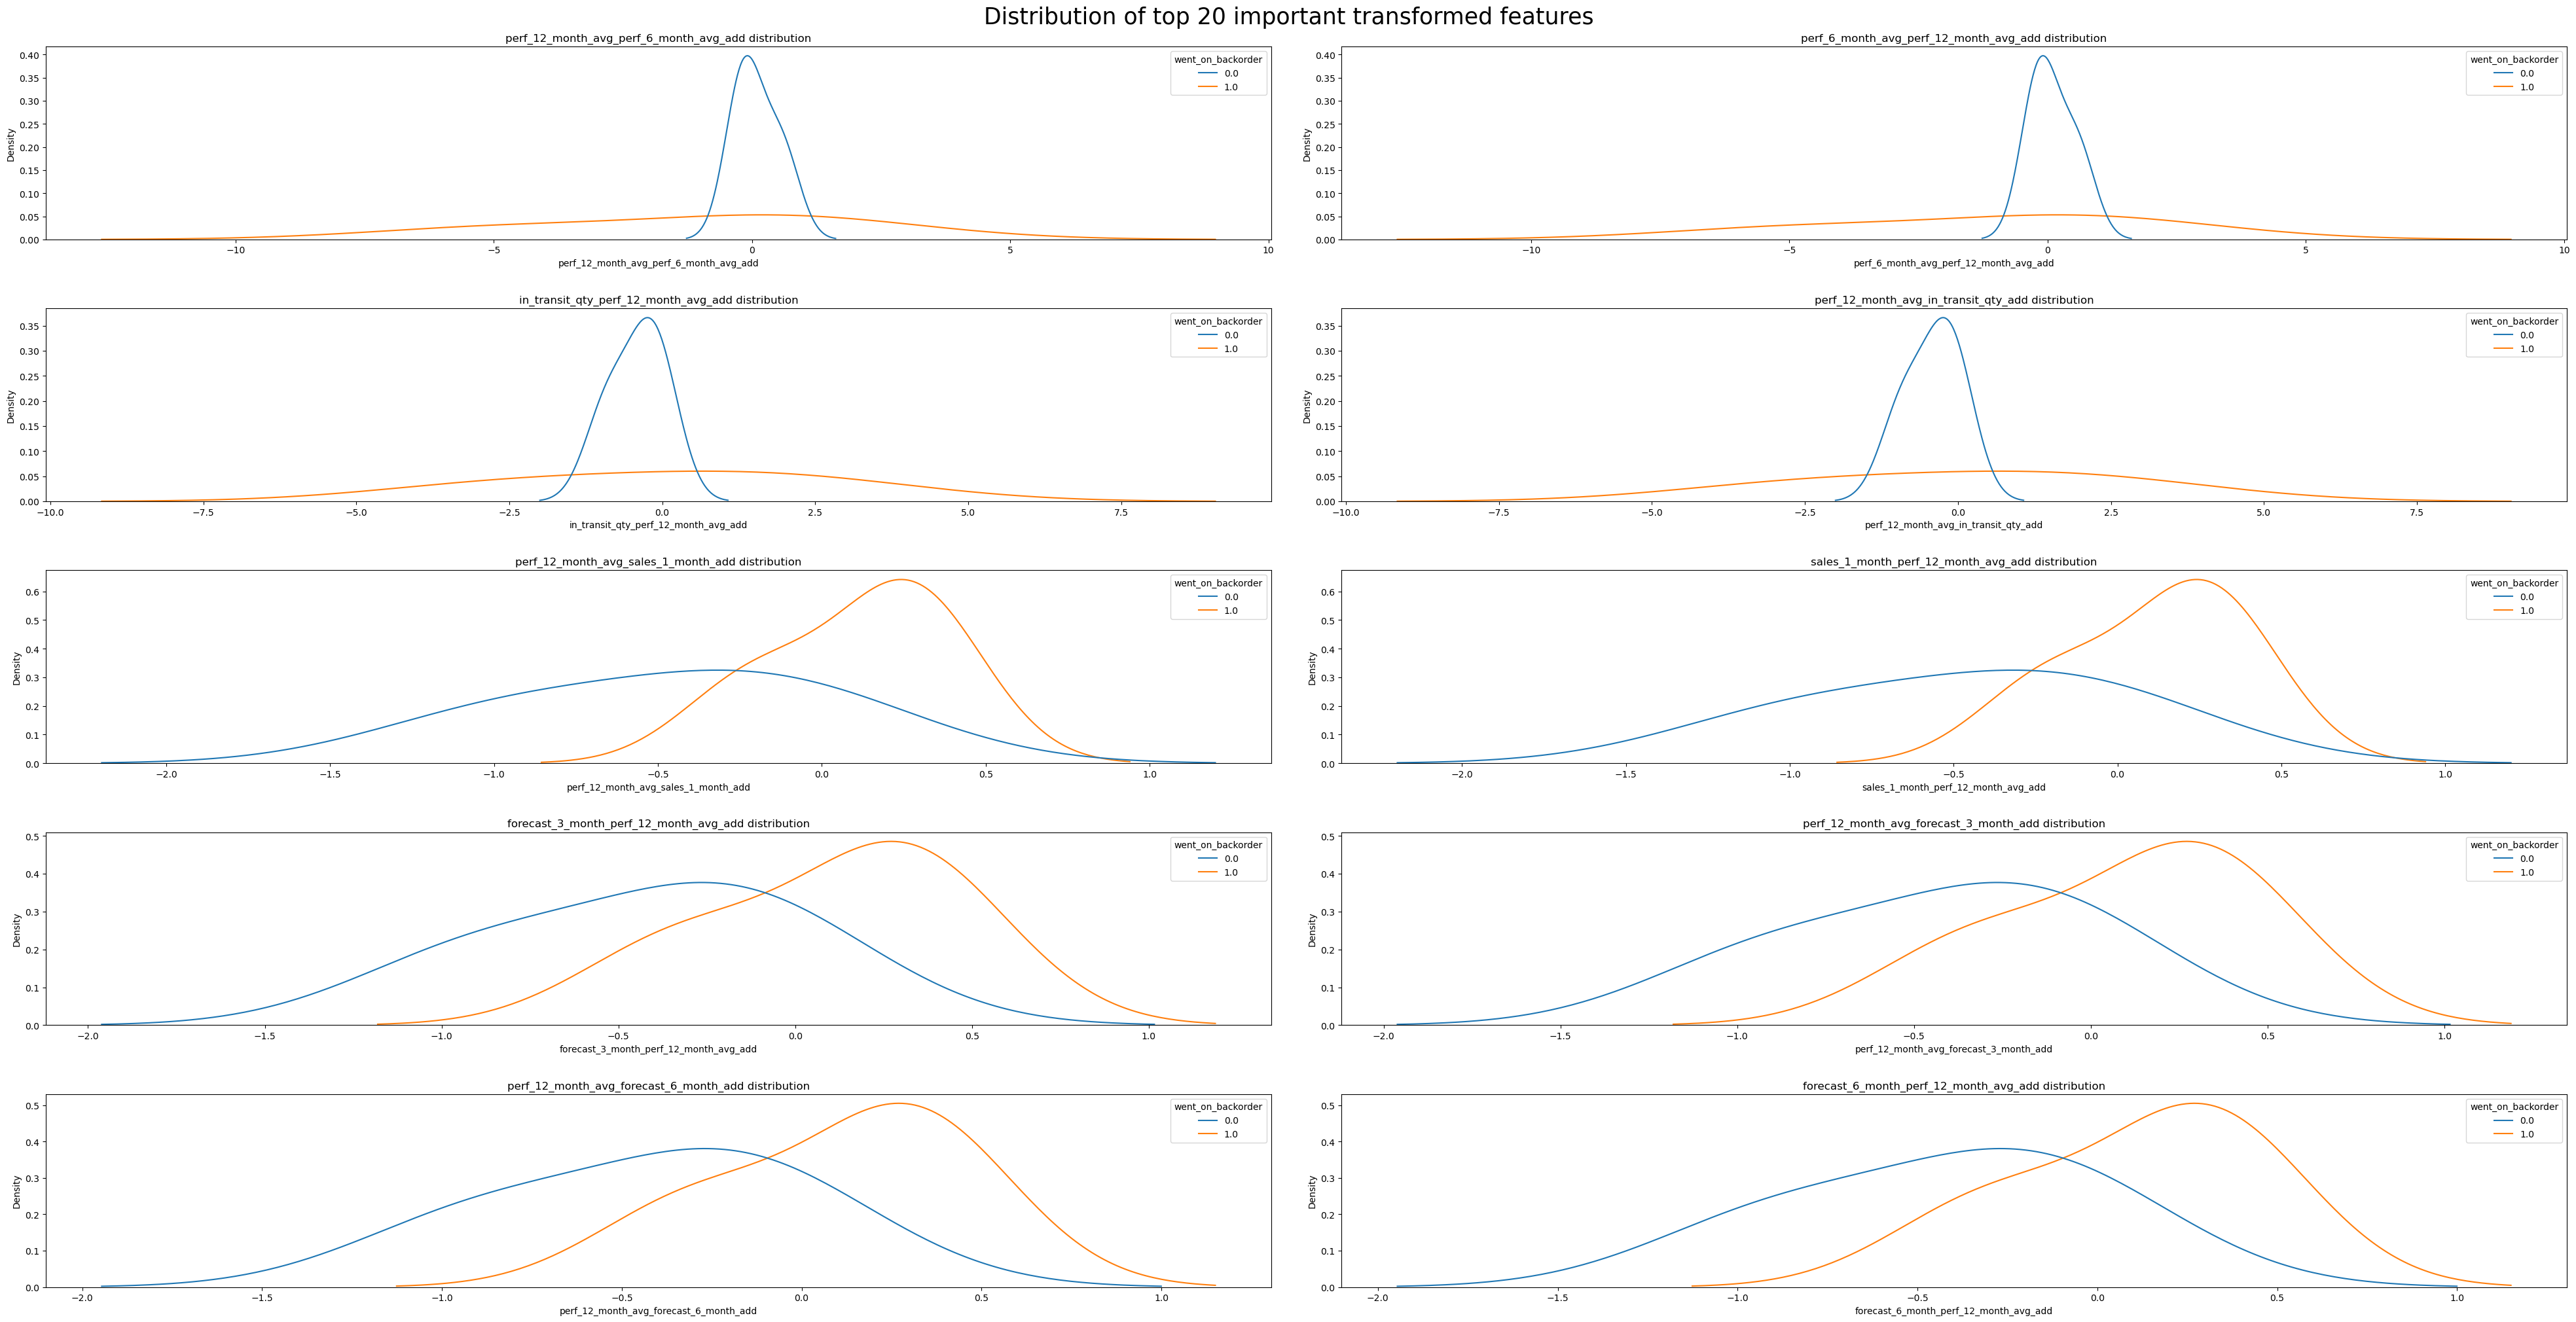

In [41]:
# Distribution of  newly created tranformed features
fig = plt.figure(figsize=(40, 40))
for i, j in enumerate(sorted_idx[:10]):
    ax1 = fig.add_subplot(10, 2, i + 1)
    ax1.title.set_text(X_train_iter_trans_plt.columns[j] + ' distribution')
    sns.kdeplot(data=X_train_iter_trans_plt,
                x=X_train_iter_trans_plt.columns[j], hue='went_on_backorder')

fig.tight_layout(pad=3.0)
fig.suptitle("Distribution of top 20 important transformed features",
             fontsize=25, y=1, x=.5)
fig.set_facecolor('None')
plt.savefig('images/top_features.png')
plt.show()


* These newly created features are less skewed and  we are able to see some seperation between positve and negative points which will be helpful in classification

## 2.9 Recursive Feature Selection can be used to choose the most suitable features 

In [42]:
# Assigning remaning columns to train and test data

for cols in ['potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']:
    X_train_iter_trans[cols] = X_train_iter_under[cols]
    X_test_iter_trans[cols] = X_test_iter_stand[cols]


In [43]:
def best_feat(X_train, X_test, y_train, y_test, num_folds=4):
    roc_score = 1
    imp_cols = set()
    train_data = X_train
    target_train_data = y_train
    test_data = X_test
    target_test_data = y_test
    cols_list = list(train_data.columns)
    imp_cols_list = list(imp_cols)
    iter = 1

    while (roc_score > 0.8) & (len(imp_cols_list) != len(cols_list)):

        # Performing K-folds split
        train_data_rem = train_data[train_data.columns[~train_data.columns.isin(
            imp_cols_list)]]
        Kfold = StratifiedKFold(
            n_splits=num_folds, shuffle=True, random_state=33)
        splits = Kfold.split(train_data_rem, target_train_data)
        model_feature_importance = np.zeros_like(train_data_rem.columns)
        roc_scores = []

        print(f"Iteration - {iter}")
        print('*' * 20)

        # Performing K-Fold Cross validation
        for fold_num, (train_idx, val_idx) in enumerate(splits, 1):
            print(f"Fold - {fold_num}")

            # defining the train and validation data
            x_train = train_data_rem.iloc[train_idx]
            x_val = train_data_rem.iloc[val_idx]
            y_train = target_train_data.iloc[train_idx]
            y_val = target_train_data.iloc[val_idx]

            # Implementing the XGB Classifier
            xg = XGBClassifier(n_jobs=-1, random_state=33)
            xg.fit(x_train, y_train)

            # Adding the feature importance of each feature averaged over different folds
            model_feature_importance += xg.feature_importances_

            # ROC-AUC Score for each K-fold
            roc = roc_auc_score(y_val, xg.predict_proba(x_val)[:, 1])
            print(f"ROC score at the end of Fold-{fold_num} is {roc}")
            roc_scores.append(roc)

        # Mean of the scores over K-folds
        roc_score = mean(roc_scores)
        print(f'ROC score at the end of iteration {iter} is {roc_score}')

        # Average feature importances
        model_feature_importance = model_feature_importance / num_folds

        # getting the non-zero feature important indices
        imp_cols_idx = np.where(np.abs(model_feature_importance) > 0)

        # getting the non-zero feature important column names
        imp_cols_names = x_train.columns[imp_cols_idx]

        # Appending important columns at each iteration
        if roc_score > 0.8:
            imp_cols.update(imp_cols_names)

        imp_cols_list = list(imp_cols)

        print(
            f"Number of features at the end of iteration {iter} is {len(imp_cols)}")
        print('*' * 20)
        iter += 1

    # Storing train and test data
    train_data = train_data[imp_cols_list]
    test_data = test_data[imp_cols_list]

    return train_data, test_data


In [45]:
x_train, x_test = best_feat(X_train_iter_trans, X_test_iter_trans, y_train, y_test, 2)


Iteration - 1
********************
Fold - 1
ROC score at the end of Fold-1 is 0.5
Fold - 2
ROC score at the end of Fold-2 is 0.5
ROC score at the end of iteration 1 is 0.5
Number of features at the end of iteration 1 is 0
********************


# 3. Training Model

## 3.1 Train-Test Split

In [48]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, random_state=50, stratify=y_train, test_size=0.2)


## 3.2 Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

# Example data (replace this with your actual data)
x_train = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y_train = np.array([0, 1, 0, 1])

# Ensure x_train and y_train are not empty and are numpy arrays
if x_train is None or y_train is None or len(x_train) == 0 or len(y_train) == 0:
    raise ValueError("x_train and y_train must be defined and not empty")

# Convert x_train and y_train to numpy arrays if they are not already
x_train = np.array(x_train)
y_train = np.array(y_train)

# Ensure x_train has at least one feature
if x_train.shape[1] == 0:
    raise ValueError("x_train must have at least one feature")

# Ensure y_train is a 1-dimensional array and of integer type
y_train = np.ravel(y_train).astype(int)

# Define the decision tree classifier
dt = DecisionTreeClassifier()

# Define the grid search parameters
parameters = {'max_depth': [2, 4, 6, 8, 10]}

# Determine the number of splits for cross-validation
min_class_count = min(np.bincount(y_train))
cv_splits = min(5, min_class_count)

# Perform grid search with cross-validation
skf = StratifiedKFold(n_splits=cv_splits)
clf = GridSearchCV(dt, parameters, scoring='f1', cv=skf, error_score='raise')
gs = clf.fit(x_train, y_train)
print(f"Best Params : {gs.best_params_}")
print(f"Best Score : {gs.best_score_}")

Best Params : {'max_depth': 2}
Best Score : 0.3333333333333333


In [ ]:
# Training on best parameters
dt = DecisionTreeClassifier(criterion=gs.best_params_[
                            'criterion'], max_depth=gs.best_params_['max_depth'])
dt.fit(x_train, y_train)

# Storing predictions for train,cv and test data
y_pred_train = dt.predict(x_train)
y_prob_train = dt.predict_proba(x_train)[:, 1]

y_pred_valid = dt.predict(x_cv)
y_prob_valid = dt.predict_proba(x_cv)[:, 1]

y_pred_test = dt.predict(x_test)
y_prob_test = dt.predict_proba(x_test)[:, 1]

# Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_train), 4)
        rs = round(recall_score(y_train, y_pred_train), 4)
        ps = round(average_precision_score(y_train, y_prob_train), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_valid), 4)
        rs = round(recall_score(y_cv, y_pred_valid), 4)
        ps = round(average_precision_score(y_cv, y_prob_valid), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Decision Tree', acc, rs, ps])

print(x)


+----------+---------------+----------+--------+-----------+
| Data Set |     Model     | Accuracy | Recall | Precision |
+----------+---------------+----------+--------+-----------+
|  Train   | Decision Tree |  0.946   | 0.9651 |   0.9814  |
|    CV    | Decision Tree |  0.8818  | 0.9079 |   0.8445  |
|   Test   | Decision Tree |  0.8633  | 0.8065 |   0.0605  |
+----------+---------------+----------+--------+-----------+


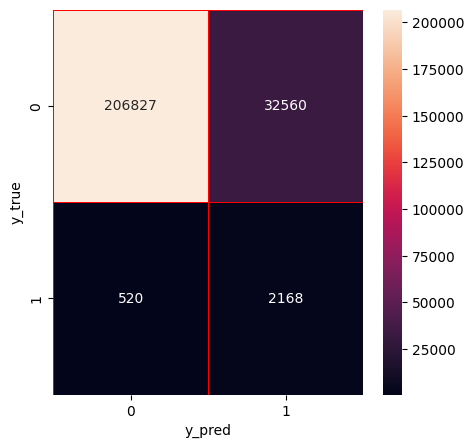

In [ ]:
# Plot confusion matrix for test data
y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


## 3.3 Random Forest

In [ ]:
# Define the grid search parameters
rf = RandomForestClassifier(n_jobs=-1)
parameters = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [10, 20, 30, 40, 50, 70, 90, 120]}
clf = GridSearchCV(rf, parameters, scoring='f1')
gs = clf.fit(x_train, y_train)
print(f"Best Params : {gs.best_params_}")
print(f"Best Score : {gs.best_score_}")


Best Params : {'max_depth': 120, 'n_estimators': 150}
Best Score : 0.9172510745051676


In [ ]:
# Training on best parameters
rf = RandomForestClassifier(n_estimators=gs.best_params_[
                            'n_estimators'], max_depth=gs.best_params_['max_depth'])
rf.fit(x_train, y_train)

# Storing predictions for train,cv and test data
y_pred_train = rf.predict(x_train)
y_prob_train = rf.predict_proba(x_train)[:, 1]

y_pred_valid = rf.predict(x_cv)
y_prob_valid = rf.predict_proba(x_cv)[:, 1]

y_pred_test = rf.predict(x_test)
y_prob_test = rf.predict_proba(x_test)[:, 1]

# Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_train), 4)
        rs = round(recall_score(y_train, y_pred_train), 4)
        ps = round(average_precision_score(y_train, y_prob_train), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_valid), 4)
        rs = round(recall_score(y_cv, y_pred_valid), 4)
        ps = round(average_precision_score(y_cv, y_prob_valid), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Random Forest', acc, rs, ps])

print(x)


+----------+---------------+----------+--------+-----------+
| Data Set |     Model     | Accuracy | Recall | Precision |
+----------+---------------+----------+--------+-----------+
|  Train   | Random Forest |  0.9981  | 0.9982 |   0.9998  |
|    CV    | Random Forest |  0.9194  | 0.9513 |   0.9727  |
|   Test   | Random Forest |  0.9003  | 0.8077 |   0.1878  |
+----------+---------------+----------+--------+-----------+


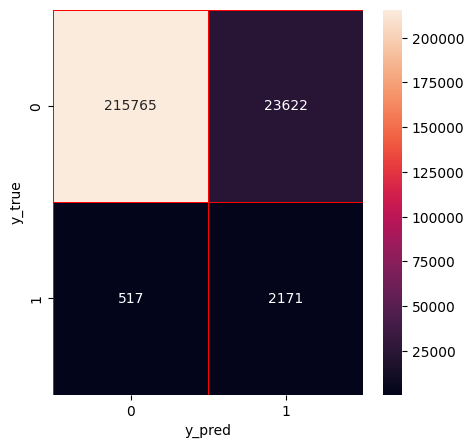

In [ ]:
# Plot confusion matrix for test data
y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


## 3.4 Light GBM

In [ ]:
# Define the grid search parameters
lgbm = LGBMClassifier()
parameters = {'n_estimators': [10, 100, 200, 500],
              'max_depth': [5, 7, 10, 20, 30, 50]}
clf = GridSearchCV(lgbm, parameters, n_jobs=-1, scoring='f1')
gs = clf.fit(x_train, np.ravel(y_train))
print(f"Best Params : {gs.best_params_}")
print(f"Best Score : {gs.best_score_}")


Best Params : {'max_depth': 10, 'n_estimators': 500}
Best Score : 0.9216593855334901


In [ ]:
# Training on best parameters
lgbm = LGBMClassifier(n_estimators=gs.best_params_[
                      'n_estimators'], max_depth=gs.best_params_['max_depth'], n_jobs=-1)
lgbm.fit(x_train, y_train)

# Storing predictions for train,cv and test data
y_pred_tr = lgbm.predict(x_train)
y_prob_tr = lgbm.predict_proba(x_train)[:, 1]

y_pred_cv = lgbm.predict(x_cv)
y_prob_cv = lgbm.predict_proba(x_cv)[:, 1]

y_pred_test = lgbm.predict(x_test)
y_prob_test = lgbm.predict_proba(x_test)[:, 1]

# Displaying results
x = PrettyTable()
x.field_names = ['Data Set', "Model", "Accuracy", "Recall", "Precision"]
dataset_type = ['Train', 'CV', 'Test']

for k in dataset_type:
    if k == 'Train':
        acc = round(accuracy_score(y_train, y_pred_tr), 4)
        rs = round(recall_score(y_train, y_pred_tr), 4)
        ps = round(average_precision_score(y_train, y_prob_tr), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])
    elif k == 'CV':
        acc = round(accuracy_score(y_cv, y_pred_cv), 4)
        rs = round(recall_score(y_cv, y_pred_cv), 4)
        ps = round(average_precision_score(y_cv, y_prob_cv), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])
    elif k == 'Test':
        acc = round(accuracy_score(y_test, y_pred_test), 4)
        rs = round(recall_score(y_test, y_pred_test), 4)
        ps = round(average_precision_score(y_test, y_prob_test), 4)
        x.add_row([k, 'Light GBM', acc, rs, ps])

print(x)


+----------+-----------+----------+--------+-----------+
| Data Set |   Model   | Accuracy | Recall | Precision |
+----------+-----------+----------+--------+-----------+
|  Train   | Light GBM |  0.9941  | 0.9954 |   0.9997  |
|    CV    | Light GBM |  0.9221  | 0.9513 |   0.9675  |
|   Test   | Light GBM |  0.9069  | 0.7939 |   0.2052  |
+----------+-----------+----------+--------+-----------+


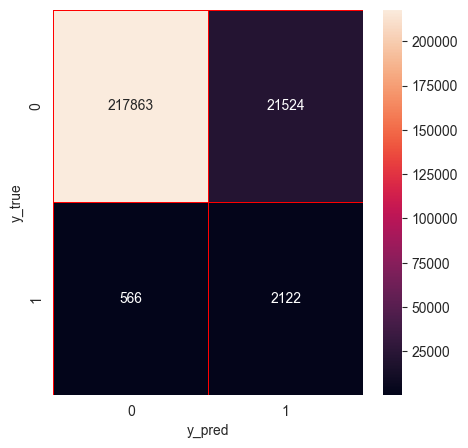

In [ ]:
# Plot confusion matrix for test data
y_pred = y_pred_test
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
f, ax = pyplot.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


##### Considering both Accuracy and Recall we are moving ahead with Random Forest.

## 3.5 Saving the best performed model and features

In [ ]:
# Saving model using joblib
joblib.dump(rf, open('models_pkl/backorder_best_model.pkl', 'wb'))

# Saving best feature columns for prediction
joblib.dump(x_test.columns, open('models_pkl/test_best_feat.pkl', 'wb'))

# Saving the test data
x_test.to_csv('models_pkl/Test_dataset.csv')

# #Saving the standardization object instance
joblib.dump(sc, open('models_pkl/sc.pkl', 'wb'))


In [ ]:
testing = pd.read_csv('models_pkl/Test_dataset.csv')
testing.drop(['Unnamed: 0'], axis=1, inplace=True)


## 3.6 Creating a Pie Chart

[[0.80666667 0.19333333]]


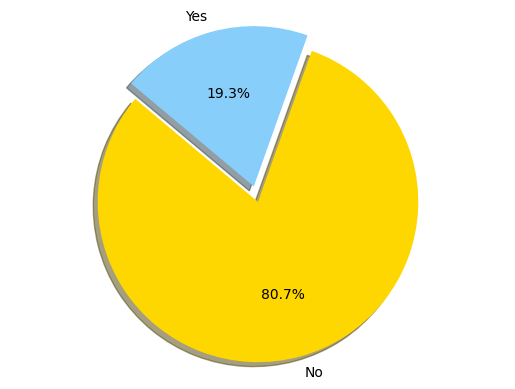

In [ ]:
# Creating a Pie Chart
filename = 'models_pkl/backorder_best_model.pkl'
model = joblib.load(filename)


def create_piechart(df):
    new = df[5:6:]

    predictions = model.predict_proba(new)
    arr = np.array(predictions)
    print(predictions)

    labels = ['No', 'Yes']
    # _colors = ['#FFC107', '#03A9F4']  # custom colors for the pie chart
    _colors = ['gold', 'lightskyblue']
    explode = (0.1, 0)  # explode 1st slice

    fig, ax = plt.subplots(facecolor='None')
    ax.pie(arr[0], explode=explode, labels=labels, colors=_colors,
           autopct='%1.1f%%', shadow=True, startangle=140)
    ax.axis('equal')

    fig.set_facecolor('None')
    # plt.savefig('images/piechart.png')  # save the figure with no padding and no background
    plt.show()


create_piechart(testing)


In [ ]:
testing = pd.concat([testing, y_test], axis=1)
testing


,lead_time_sales_3_month_mult,forecast_3_month_square,sales_9_month_pieces_past_due_mult,lead_time_forecast_6_month_mult,forecast_6_month_lead_time_add,national_inv_forecast_9_month_mult,lead_time_square_root,national_inv_pieces_past_due_add,in_transit_qty_national_inv_add,forecast_9_month_sales_9_month_add,...,min_bank_in_transit_qty_mult,sales_9_month_local_bo_qty_mult,forecast_6_month_national_inv_add,sales_9_month_forecast_3_month_add,forecast_3_month_pieces_past_due_mult,sales_6_month_in_transit_qty_add,sales_6_month_forecast_6_month_add,sales_1_month_perf_6_month_avg_mult,forecast_6_month_pieces_past_due_add,went_on_backorder
0,-0.004834,0.001256,0.000307,-0.005051,0.108191,0.000516,0.378697,-0.023318,-0.047466,-0.070615,...,0.001353,0.000658,-0.049879,-0.070835,0.000307,-0.068356,-0.070768,0.000743,-0.043879,0.0
1,-0.059653,0.001256,0.000307,-0.062328,1.734450,0.000579,1.330290,-0.025107,-0.049256,-0.070615,...,0.001353,0.000658,-0.051668,-0.070835,0.000307,-0.068356,-0.070768,0.004281,-0.043879,0.0
2,0.000344,0.001256,0.000307,0.000359,-0.045413,0.000570,0.100957,-0.024837,-0.048985,-0.070615,...,0.001380,0.000658,-0.051398,-0.070835,0.000307,-0.068356,-0.070768,-0.017614,-0.043879,0.0
3,0.029196,0.001256,0.000305,0.030506,-0.901358,0.000579,0.930665,-0.025107,-0.049256,-0.070480,...,0.001380,0.000655,-0.051668,-0.070700,0.000307,-0.068356,-0.070768,0.000004,-0.043879,0.0
4,0.000344,0.001256,0.000307,0.000359,-0.045413,0.000588,0.100957,-0.025344,-0.049492,-0.070615,...,0.001380,0.000658,-0.051905,-0.070835,0.000307,-0.068356,-0.070768,0.030206,-0.043879,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242070,-0.018891,0.001256,0.000307,-0.019739,0.525218,0.000576,0.748624,-0.025006,-0.049154,-0.070615,...,0.001353,0.000658,-0.051567,-0.070835,0.000307,-0.068356,-0.070768,0.037756,-0.043879,0.0
242071,-0.018891,0.001256,0.000307,-0.019739,0.525218,0.000574,0.748624,-0.024972,-0.049120,-0.070615,...,0.001353,0.000658,-0.051533,-0.070835,0.000307,-0.068356,-0.070768,0.037756,-0.043879,0.0
242072,-0.018891,0.001256,0.000307,-0.019739,0.525218,0.000574,0.748624,-0.024972,-0.049120,-0.070615,...,0.001353,0.000658,-0.051533,-0.070835,0.000307,-0.068356,-0.070768,0.037756,-0.043879,0.0
242073,-0.018891,0.001256,0.000307,-0.019739,0.525218,0.000578,0.748624,-0.025073,-0.049222,-0.070615,...,0.001353,0.000658,-0.051634,-0.070835,0.000307,-0.068356,-0.070768,0.037756,-0.043879,0.0


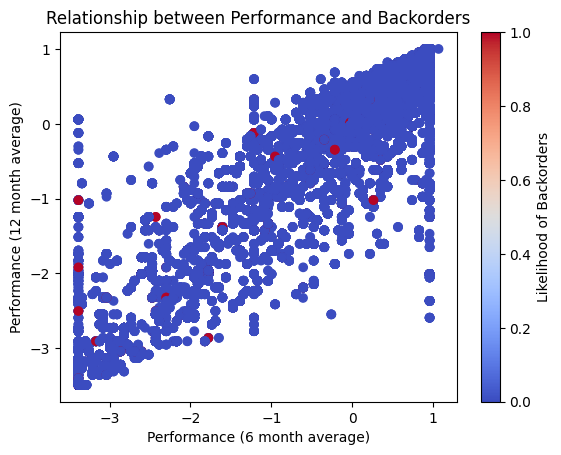

In [ ]:
# Performance chart
data = testing.copy()
fig, ax = plt.subplots(facecolor='None')
plt.scatter(data['perf_6_month_avg'], data['perf_12_month_avg'],
            c=data['went_on_backorder'], cmap='coolwarm')
plt.xlabel('Performance (6 month average)')
plt.ylabel('Performance (12 month average)')
plt.title('Relationship between Performance and Backorders')
plt.colorbar(label='Likelihood of Backorders')
fig.set_facecolor('None')  # set the background color of the figure to None
# plt.savefig('images/performance.png')  # save the figure with no padding
plt.show()


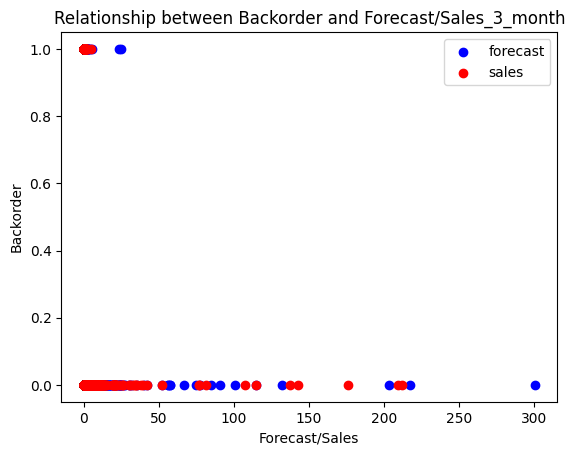

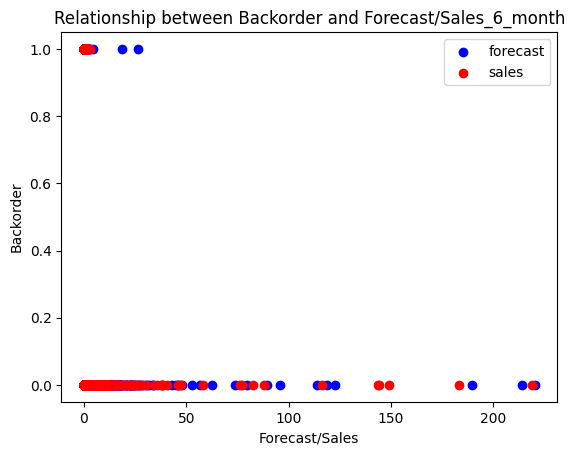

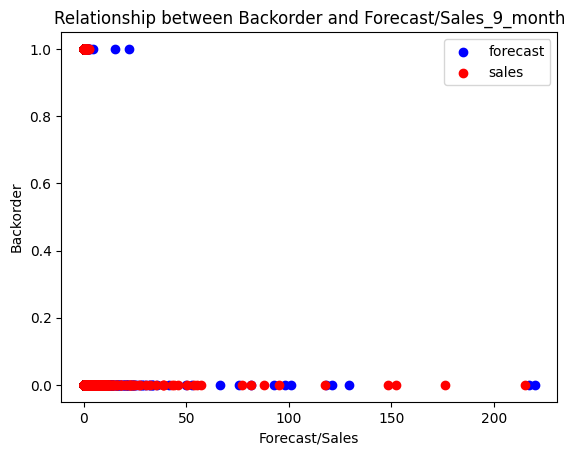

In [ ]:
# Forecast and Sales chart
def forecast_sales(data, forcast, sales):
    for i in range(len(sales)):
        fig, ax = plt.subplots(facecolor='None')

        # create a scatter plot of forecast vs. backorders
        plt.scatter(data[forcast[i]], data['went_on_backorder'],
                    color='blue', label='forecast')

        # create a scatter plot of sales vs. backorders
        plt.scatter(data[sales[i]], data['went_on_backorder'],
                    color='red', label='sales')

        # set axis labels and title
        plt.xlabel('Forecast/Sales')
        plt.ylabel('Backorder')
        plt.title(
            'Relationship between Backorder and Forecast/Sales' + sales[i][5:])

        # show the legend
        plt.legend()

        # display the plot
        fig.set_facecolor('None')
        # save the figure with no padding and no background
        plt.savefig('images/' + sales[i][5:] + 'sales.png')
        plt.show()



forcast_col = ['forecast_3_month', 'forecast_6_month', 'forecast_9_month']
sales_col = ['sales_3_month', 'sales_6_month', 'sales_9_month']
forecast_sales(testing, forcast_col, sales_col)
